In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm


In [29]:
class CrowdDataset(Dataset):
    def __init__(self, images_path, gts_path):
        self.images = np.load(images_path)
        self.gts = np.load(gts_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # [3,H,W]
        gt = self.gts[idx]      # [64,64]
        return torch.tensor(img, dtype=torch.float32), torch.tensor(gt, dtype=torch.float32).unsqueeze(0)


In [31]:
OUTPUT_PATH = r"C:\Users\nshre\OneDrive\Desktop\DeepVision\dataset\crowd\part_B\processed_crowd"

train_dataset = CrowdDataset(
    images_path=os.path.join(OUTPUT_PATH, 'train_images.npy'),
    gts_path=os.path.join(OUTPUT_PATH, 'train_gts.npy')
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
print(f"Number of training samples: {len(train_dataset)}")


Number of training samples: 400


In [32]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        
        # Load pretrained VGG16 features only (ignore classifier)
        pretrained_vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.frontend = nn.Sequential(*list(pretrained_vgg.features.children())[:23])
        
        # Backend of CSRNet
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model safely
model = CSRNet().to(device)
print(model)


CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [33]:
import torch.optim as optim
import torch.nn as nn

# ----------------- LOSS FUNCTION -----------------
# CSRNet uses Euclidean loss (MSE) between predicted and ground-truth density maps
criterion = nn.MSELoss()

# ----------------- OPTIMIZER -----------------
# Adam optimizer is commonly used
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

print("Loss function and optimizer are ready.")


Loss function and optimizer are ready.


In [34]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

# ----------------- CUSTOM DATASET -----------------
class CrowdDataset(Dataset):
    def __init__(self, images_path, gts_path):
        self.images = np.load(images_path)        # shape: [N, 3, H, W]
        self.gts = np.load(gts_path)             # shape: [N, h, w]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32)
        gt = torch.tensor(self.gts[idx], dtype=torch.float32)
        gt = gt.unsqueeze(0)  # add channel dimension [1, h, w]
        return img, gt

# Paths to processed .npy
train_dataset = CrowdDataset(
    images_path=r"C:\Users\nshre\OneDrive\Desktop\DeepVision\dataset\crowd\part_A\processed\train_images.npy",
    gts_path=r"C:\Users\nshre\OneDrive\Desktop\DeepVision\dataset\crowd\part_A\processed\train_gts.npy"
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

print(f"Number of training samples: {len(train_dataset)}")


Number of training samples: 300


In [35]:
# ----------------- TRAINING LOOP -----------------
num_epochs = 5   # For demonstration; increase to 50+ for actual training

batch_losses = []
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, gts) in enumerate(train_loader):
        images = images.to(device)
        gts = gts.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, gts)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        running_loss += loss.item()

        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] finished, Average Loss: {epoch_loss:.4f}")


Epoch [1/5], Batch [10/75], Loss: 0.3230
Epoch [1/5], Batch [20/75], Loss: 0.2016
Epoch [1/5], Batch [30/75], Loss: 0.1592
Epoch [1/5], Batch [40/75], Loss: 0.0741
Epoch [1/5], Batch [50/75], Loss: 0.3850
Epoch [1/5], Batch [60/75], Loss: 0.1118
Epoch [1/5], Batch [70/75], Loss: 0.4949
Epoch [1/5] finished, Average Loss: 0.2072
Epoch [2/5], Batch [10/75], Loss: 0.2555
Epoch [2/5], Batch [20/75], Loss: 0.0858
Epoch [2/5], Batch [30/75], Loss: 0.0963
Epoch [2/5], Batch [40/75], Loss: 0.0937
Epoch [2/5], Batch [50/75], Loss: 0.2132
Epoch [2/5], Batch [60/75], Loss: 0.2281
Epoch [2/5], Batch [70/75], Loss: 0.0819
Epoch [2/5] finished, Average Loss: 0.1722
Epoch [3/5], Batch [10/75], Loss: 0.1049
Epoch [3/5], Batch [20/75], Loss: 0.0814
Epoch [3/5], Batch [30/75], Loss: 0.1314
Epoch [3/5], Batch [40/75], Loss: 0.2439
Epoch [3/5], Batch [50/75], Loss: 0.0432
Epoch [3/5], Batch [60/75], Loss: 0.1413
Epoch [3/5], Batch [70/75], Loss: 0.0800
Epoch [3/5] finished, Average Loss: 0.1538
Epoch [4/5

In [36]:
model_path_b = "csrnet_trained_partB.pth"
torch.save(model.state_dict(), model_path_b)
print("Model saved as", model_path_b)


Model saved as csrnet_trained_partB.pth


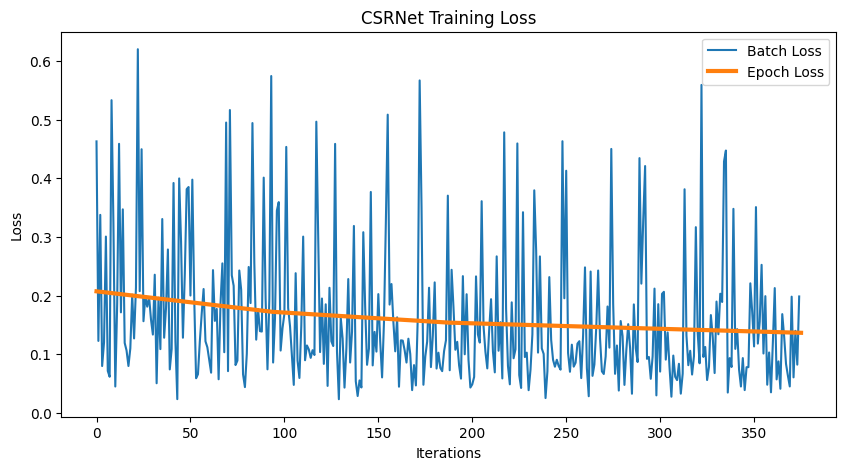

In [38]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,5))
plt.plot(batch_losses, label='Batch Loss')
plt.plot(np.linspace(0, len(batch_losses), len(epoch_losses)), epoch_losses, label='Epoch Loss', linewidth=3)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("CSRNet Training Loss")
plt.legend()
plt.show()
